In [2]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.recommender import *
from ctrace.problem_label import *
from ctrace.utils import *
from ctrace.exec.param import GraphParam, SIRParam, FileParam, ParamBase, LambdaParam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from ctrace.exec.param import GraphParam

# load graphs
graphs = {
    "montgomery": GraphParam('montgomery').data,
    "cville": GraphParam('cville').data
}

In [4]:
df_input = pd.read_csv(PROJECT_ROOT / 'output/run_PsmmT/input.csv')
df_main = pd.read_csv(PROJECT_ROOT / 'output/run_PsmmT/main.csv')

df_input.head()

,id,graph,budget,agent,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,discovery_rate,snitch_rate,from_cache,trial_id,seed
0,0,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,0,15795
1,1,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,1,860
2,2,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,2,76820
3,3,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,3,54886
4,4,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,4,6265


In [5]:
df_main.head()

,id,peak,total
0,40,5114,39164
1,41,4958,39465
2,42,5054,39173
3,43,4965,39129
4,44,5013,39026


In [6]:
result = pd.merge(df_input, df_main, how="left", on=["id"])
result.head()


,id,graph,budget,agent,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,discovery_rate,snitch_rate,from_cache,trial_id,seed,peak,total
0,0,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,0,15795,4752,38700
1,1,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,1,860,4798,38478
2,2,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,2,76820,4851,38584
3,3,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,3,54886,4811,38677
4,4,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,4,6265,4764,38656


In [7]:
result['frac'] = result.apply(lambda row: row['total'] / len(graphs[row['graph']]) * 100, axis=1)

In [8]:
# Rename the labels
result['agent'] = result['agent'].replace({'DepRound_fair': "DepRoundFair", 'DegGreedy_fair': "DegGreedyFair"})
result['graph'] = result['graph'].replace({'montgomery': "Montgomery", 'cville': "Albemarle"})

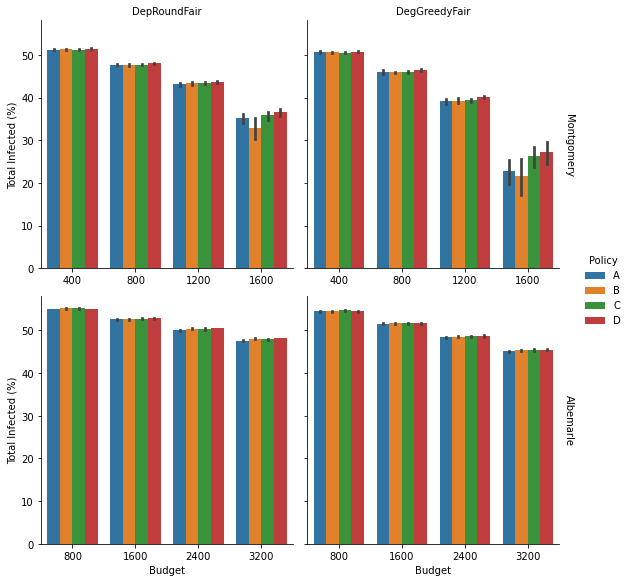

In [9]:
result["budget"] = result["budget"].astype(int)

g = sns.catplot(x="budget", y="frac",
                hue="policy", col="agent", row="graph",
                data=result[result['policy'] != 'A_ONLY'], kind="bar",
                height=4, aspect=1,
                sharex=False,
                margin_titles=True);

(g.set_axis_labels("Budget", "Total Infected (%)"))
#     .set_titles("{row_name} {col_name}")
#     .despine(left=True))
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g._legend.set_title("Policy")

g.savefig("Fairness.png")

### Individual Run Analysis

In [10]:
from typing import List
def compute_ratio(observed: List[float], expected: List[float]):
    """
    observed: 
    """
    if np.sum(observed) == 0 or np.sum(expected) == 0:
        return None
    norm_obs = np.array(observed) / np.sum(observed)
    norm_expected = np.array(expected) / np.sum(expected)
    return norm_obs / norm_expected

assert list(compute_ratio([1, 1, 2], [2, 1, 1])) == [0.5, 1, 2]
assert list(compute_ratio([2, 4, 2], [2, 1, 1])) == [0.5, 2, 1]

def get_label_freq(G, nodes=None, cat='age_group', labels=[0,1,2,3,4]):
    if nodes is None:
        nodes = G.nodes
    age_groups = [G.nodes[n][cat] for n in nodes]
    
    return [age_groups.count(l) for l in labels]


In [11]:
from ctrace.exec.param import GraphParam

# load graphs
graphs = {
    "montgomery": GraphParam('montgomery').data,
    "cville": GraphParam('cville').data
}

In [12]:
run_dir = PROJECT_ROOT / f"output/run_PsmmT"
df_in = pd.read_csv(run_dir / 'input.csv')

In [13]:
df = df_in[(df_in["trial_id"] == 0)]
df

,id,graph,budget,agent,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,discovery_rate,snitch_rate,from_cache,trial_id,seed
0,0,montgomery,400,DepRound_fair,A,0.05,False,-1.0,False,1.0,1.0,c7.json,0,15795
10,10,montgomery,400,DepRound_fair,B,0.05,False,-1.0,False,1.0,1.0,c7.json,0,16023
20,20,montgomery,400,DepRound_fair,C,0.05,False,-1.0,False,1.0,1.0,c7.json,0,83104
30,30,montgomery,400,DepRound_fair,D,0.05,False,-1.0,False,1.0,1.0,c7.json,0,59150
40,40,montgomery,400,DepRound_fair,A_ONLY,0.05,False,-1.0,False,1.0,1.0,c7.json,0,3890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,750,cville,3200,DegGreedy_fair,A,0.05,False,-1.0,False,1.0,1.0,b5.json,0,66203
760,760,cville,3200,DegGreedy_fair,B,0.05,False,-1.0,False,1.0,1.0,b5.json,0,20159
770,770,cville,3200,DegGreedy_fair,C,0.05,False,-1.0,False,1.0,1.0,b5.json,0,34349
780,780,cville,3200,DegGreedy_fair,D,0.05,False,-1.0,False,1.0,1.0,b5.json,0,58141


### Retrieve Proportions for Each Category

In [14]:
# Assumes age_label & age_label = range(5)
entries = []
for index, row in df.iterrows():
    G = graphs[row['graph']]
    with open(run_dir / "data" / str(index) / "sir_history.json", "r") as f:
        sir_history = json.load(f)
        
    quarantines = [step['action'] for step in sir_history]
    
    observed_freq = [get_label_freq(G, q) for q in quarantines]
    population_freq = get_label_freq(G)
    
    ratios = [compute_ratio(obs, population_freq) for obs in observed_freq]
    
    for t, ratio in enumerate(ratios):
        if ratio is not None:
            entry = {
                'id': index,
                't': t,
                **dict(enumerate(ratio)),
            }
            print(entry)
            entries.append(entry)
ratios_df = pd.DataFrame(entries)
ratios_df.head()   
    
    


{'id': 0, 't': 0, 0: 0.9989073179832432, 1: 1.127981696276635, 2: 0.8778477183829793, 3: 1.1001417402097198, 4: 0.9994975380246269}
{'id': 0, 't': 1, 0: 1.0005853935583289, 1: 1.1209157959282372, 2: 0.9692763408042258, 3: 0.771084706705873, 4: 0.9902475817472632}
{'id': 0, 't': 2, 0: 1.036337304404185, 1: 1.115311216948596, 2: 0.9885407080777097, 3: 0.7192774529740721, 4: 0.8850967156515581}
{'id': 0, 't': 3, 0: 1.1323220244679784, 1: 0.9938724294724329, 2: 0.7855632498936502, 3: 0.961440204476621, 4: 0.9375403806967845}
{'id': 0, 't': 4, 0: 1.0681181983383508, 1: 0.9938724294724329, 2: 0.9064191344926734, 3: 1.009512214700452, 4: 0.9375403806967845}
{'id': 0, 't': 5, 0: 1.030515184716521, 1: 1.1617825176547874, 2: 0.9403192101226995, 3: 0.911084773767158, 4: 0.8516968395892351}
{'id': 0, 't': 6, 0: 1.042159424091849, 1: 0.9604068812612909, 2: 1.0247068315439674, 3: 0.7672292831723436, 4: 0.9685964058073654}
{'id': 0, 't': 7, 0: 0.9630573919444145, 1: 1.0249309428934466, 2: 0.978932665

{'id': 30, 't': 0, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 1, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 2, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 3, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 4, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 5, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 6, 0: 1.1469575784698003, 1: 1.1462920840860569, 2: 0.5786579754601228, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 30, 't': 7, 0: 1.1469575784698003, 1: 1.146292084086056

{'id': 70, 't': 0, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 1, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 2, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 3, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 4, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 5, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 6, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7534934932719548}
{'id': 70, 't': 7, 0: 0.8674958334619302, 1: 0.867464279848908, 2: 0.

{'id': 100, 't': 0, 0: 0.990999095772589, 1: 1.0701776382902672, 2: 0.9596017740734201, 3: 0.8882191325837521, 4: 1.045052442500718}
{'id': 100, 't': 1, 0: 1.0522078634526608, 1: 1.0081383549111211, 2: 0.9354608489394975, 3: 0.8162013650769613, 4: 0.9948899252606834}
{'id': 100, 't': 2, 0: 1.0844697345811023, 1: 0.9746789661223684, 2: 0.8608831719808318, 3: 1.0296772526969655, 4: 0.9673871718425622}
{'id': 100, 't': 3, 0: 1.1034441303303268, 1: 0.9425600475736262, 2: 0.8658224071722534, 3: 1.1001417402097198, 4: 0.9162060765225747}
{'id': 100, 't': 4, 0: 1.0259755344469157, 1: 0.9848736236439416, 2: 1.0622007058925909, 3: 0.7921954425746978, 4: 0.9280065689406376}
{'id': 100, 't': 5, 0: 1.0288902376697764, 1: 0.9693638027991551, 2: 0.9475313115064588, 3: 1.1282783576063877, 4: 0.9781690861806721}
{'id': 100, 't': 6, 0: 1.0976365296443777, 1: 0.8730269293099981, 2: 0.8658224071722534, 3: 1.028393365848216, 4: 1.0328141226254477}
{'id': 100, 't': 7, 0: 1.0728400323335838, 1: 0.9746789661

{'id': 130, 't': 0, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 1, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 2, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 3, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 4, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 5, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 6, 0: 1.1498686383136323, 1: 1.1462920840860569, 2: 0.5726302882157465, 3: 0.5754219623792577, 4: 1.1522957241501415}
{'id': 130, 't': 7, 0: 1.1498686383136323, 1: 1.1462920

{'id': 160, 't': 0, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 1, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 2, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 3, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 4, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 5, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 6, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.0018483930577844, 3: 1.00824874509507, 4: 0.9865295057206778}
{'id': 160, 't': 7, 0: 1.0026579086640313, 1: 1.000383444488728, 2: 1.001848

{'id': 190, 't': 0, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 1, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 2, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 3, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 4, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 5, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 6, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 7, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 8, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 9, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 10, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 11, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 12, 0: 0.0, 1: 0.0, 2: 4.822149795501023, 3: 0.0, 4: 0.0}
{'id': 190, 't': 13, 0: 0.0, 1: 0.0

{'id': 220, 't': 0, 0: 0.8694365400244849, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7479268472615674}
{'id': 220, 't': 1, 0: 0.8774801076782017, 1: 0.8754896011931786, 2: 0.8760171201246602, 3: 0.8711181936775978, 4: 1.7022981407710436}
{'id': 220, 't': 2, 0: 0.8694365400244849, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7479268472615674}
{'id': 220, 't': 3, 0: 0.8694365400244849, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7479268472615674}
{'id': 220, 't': 4, 0: 0.8694365400244849, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7479268472615674}
{'id': 220, 't': 5, 0: 0.8694365400244849, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7479268472615674}
{'id': 220, 't': 6, 0: 0.8694365400244849, 1: 0.867464279848908, 2: 0.8679869631901841, 3: 0.8631329435688866, 4: 1.7479268472615674}
{'id': 220, 't': 7, 0: 0.8694365400244849, 1: 0.8674642798489

{'id': 250, 't': 0, 0: 1.0557443700297315, 1: 1.0585129605299175, 2: 0.9001346284935243, 3: 0.9910044907642772, 4: 0.9184965917138811}
{'id': 250, 't': 1, 0: 0.9897603469028733, 1: 1.0481860048174303, 2: 1.0287252897068848, 3: 0.7512453397729199, 4: 1.024262865911237}
{'id': 250, 't': 2, 0: 1.030515184716521, 1: 0.9655703591175343, 2: 0.9563930427743695, 3: 1.102892094560244, 4: 0.9741630518177526}
{'id': 250, 't': 3, 0: 0.9936417600279827, 1: 1.0017147041112389, 2: 0.9764853335889572, 3: 0.9430526605660057, 4: 1.0687960339943343}
{'id': 250, 't': 4, 0: 1.0343965978416303, 1: 0.9604068812612909, 2: 0.9925591662406272, 3: 0.9910044907642772, 4: 0.9574631137865912}
{'id': 250, 't': 5, 0: 1.0343965978416303, 1: 0.9345894919800735, 2: 1.0005960825664622, 3: 0.8471490001694627, 4: 1.024262865911237}
{'id': 250, 't': 6, 0: 1.0732107290927233, 1: 1.0172051376799693, 2: 0.9483561264485344, 3: 0.9590366039654296, 4: 0.8572634855996223}
{'id': 250, 't': 7, 0: 0.9994638797156465, 1: 1.04818600481

{'id': 280, 't': 0, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 1, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 2, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 3, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 4, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 5, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 6, 0: 1.148898285032355, 1: 1.1514555619423004, 2: 0.5746395172972052, 3: 0.5754219623792577, 4: 1.1467290781397546}
{'id': 280, 't': 7, 0: 1.148898285032355, 1: 1.151455561942300

{'id': 310, 't': 0, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 1, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 2, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 3, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 4, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 5, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 6, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 310, 't': 7, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.001221

{'id': 330, 't': 0, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 1, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 2, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 3, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 4, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 5, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 6, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 330, 't': 7, 0: 1.1484131083917162, 1: 1.1501646

{'id': 360, 't': 0, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 1, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 2, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 3, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 4, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 5, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 6, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.00122184622035, 3: 0.9956227408271501, 4: 0.9984453256904545}
{'id': 360, 't': 7, 0: 1.000574415365889, 1: 0.9997578138167525, 2: 1.001221

{'id': 380, 't': 0, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 1, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 2, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 3, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 4, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 5, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 6, 0: 1.1484131083917162, 1: 1.1501646924782396, 2: 0.5756441318379346, 3: 0.5754219623792577, 4: 1.1481207396423514}
{'id': 380, 't': 7, 0: 1.1484131083917162, 1: 1.1501646

{'id': 410, 't': 0, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 1, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 2, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 3, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 4, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 5, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 6, 0: 0.9988894635302868, 1: 0.9979939680041962, 2: 1.0025632220580334, 3: 0.9788288576300085, 4: 1.0075450230350411}
{'id': 410, 't': 7, 0: 0.9988894635302868, 1: 0.9979939

{'id': 440, 't': 0, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 1, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 2, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 3, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 4, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 5, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 6, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 7, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 8, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 9, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 10, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 11, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 12, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 440, 't': 13, 0: 0.0, 1: 0.0

{'id': 480, 't': 0, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 1, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 2, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 3, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 4, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 5, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 6, 0: 1.1463082647637641, 1: 1.1442517046944665, 2: 0.5728932697474476, 3: 0.5593307757885763, 4: 1.1449375261761832}
{'id': 480, 't': 7, 0: 1.1463082647637641, 1: 1.1442517

{'id': 520, 't': 0, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 1, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 2, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 3, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 4, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 5, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 6, 0: 0.9010338799528923, 1: 0.9033566089693156, 2: 0.9006543231125739, 3: 0.9089125106564365, 4: 1.8032766037274883}
{'id': 520, 't': 7, 0: 0.9010338799528923, 1: 0.9033566

{'id': 560, 't': 0, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 1, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 2, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 3, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 4, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 5, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 6, 0: 1.0001603152650582, 1: 0.9979939680041962, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 1.0018203354041602}
{'id': 560, 't': 7, 0: 1.0001603152650582, 1: 0.9979939

{'id': 590, 't': 0, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 1, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 2, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 3, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 4, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 5, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 6, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 7, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 8, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 9, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 10, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 11, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 12, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 590, 't': 13, 0: 0.0, 1: 0.0

{'id': 620, 't': 0, 0: 0.9159602003703465, 1: 0.8042463580517918, 2: 0.916076973379785, 3: 0.9156416877148581, 4: 1.8342267565836905}
{'id': 620, 't': 1, 0: 0.9373908116441761, 1: 0.7485103865686167, 2: 0.8821380170088015, 3: 0.9370648467861764, 4: 1.8771419406632048}
{'id': 620, 't': 2, 0: 0.9014574971978161, 1: 0.9004888102106828, 2: 0.9015724213012717, 3: 0.901144027659373, 4: 1.8051848329377822}
{'id': 620, 't': 3, 0: 0.9014574971978161, 1: 0.9004888102106828, 2: 0.9015724213012717, 3: 0.901144027659373, 4: 1.8051848329377822}
{'id': 620, 't': 4, 0: 0.9014574971978161, 1: 0.9004888102106828, 2: 0.9015724213012717, 3: 0.901144027659373, 4: 1.8051848329377822}
{'id': 620, 't': 5, 0: 0.9014574971978161, 1: 0.9004888102106828, 2: 0.9015724213012717, 3: 0.901144027659373, 4: 1.8051848329377822}
{'id': 620, 't': 6, 0: 0.9014574971978161, 1: 0.9004888102106828, 2: 0.9015724213012717, 3: 0.901144027659373, 4: 1.8051848329377822}
{'id': 620, 't': 7, 0: 0.9014574971978161, 1: 0.9004888102106

{'id': 650, 't': 0, 0: 0.5269798526851894, 1: 0.3384002535186642, 2: 0.49026443276464265, 3: 4.47464620630861, 4: 4.217186554748941}
{'id': 650, 't': 1, 0: 0.6303424604465931, 1: 0.28104427834600926, 2: 0.44986811246193803, 3: 4.4124983423321025, 4: 3.9271357147843085}
{'id': 650, 't': 2, 0: 0.7506497580049483, 1: 0.4273020150362794, 2: 0.7142803908069139, 3: 2.501451525054466, 4: 3.110413612778631}
{'id': 650, 't': 3, 0: 0.9099298420962918, 1: 0.5305427703470583, 2: 0.7840558531479491, 3: 1.6158444633892206, 4: 2.328039636558239}
{'id': 650, 't': 4, 0: 0.9344996423018713, 1: 0.5792953492438151, 2: 0.850158922734193, 3: 1.1808094155536613, 4: 2.121950881846526}
{'id': 650, 't': 5, 0: 1.03616778108358, 1: 0.602237739312877, 2: 0.8979000285464803, 3: 1.2740312115184238, 4: 1.5113175345525618}
{'id': 650, 't': 6, 0: 1.0768350365962633, 1: 0.6681971107614302, 2: 0.9878736510388679, 3: 0.9943658236241357, 4: 1.1220387756526595}
{'id': 650, 't': 7, 0: 1.1014048368018428, 1: 0.737024280968616

{'id': 680, 't': 0, 0: 1.1612488663070557, 1: 0.8862414690874337, 2: 0.6368429121787282, 3: 0.639037786141032, 4: 1.2684995658237288}
{'id': 680, 't': 1, 0: 1.2004831758329257, 1: 0.8716104524054115, 2: 0.6004121604340062, 3: 0.6024814761041434, 4: 1.1959347434993144}
{'id': 680, 't': 2, 0: 1.1459385046508546, 1: 1.1447286749757062, 2: 0.5731320747786053, 3: 0.5751073698534758, 4: 1.141596733061038}
{'id': 680, 't': 3, 0: 1.1459385046508546, 1: 1.1447286749757062, 2: 0.5731320747786053, 3: 0.5751073698534758, 4: 1.141596733061038}
{'id': 680, 't': 4, 0: 1.1459385046508546, 1: 1.1447286749757062, 2: 0.5731320747786053, 3: 0.5751073698534758, 4: 1.141596733061038}
{'id': 680, 't': 5, 0: 1.1459385046508546, 1: 1.1447286749757062, 2: 0.5731320747786053, 3: 0.5751073698534758, 4: 1.141596733061038}
{'id': 680, 't': 6, 0: 1.1459385046508546, 1: 1.1447286749757062, 2: 0.5731320747786053, 3: 0.5751073698534758, 4: 1.141596733061038}
{'id': 680, 't': 7, 0: 1.1459385046508546, 1: 1.1447286749757

{'id': 710, 't': 0, 0: 0.9727958602854131, 1: 0.7619954495359915, 2: 1.0444742942883736, 3: 1.2817065472373452, 4: 1.2776441139424075}
{'id': 710, 't': 1, 0: 1.0702819371747894, 1: 0.7491392675612075, 2: 0.7925623139167004, 3: 1.3634480362193186, 4: 1.3591265191683264}
{'id': 710, 't': 2, 0: 1.0001603152650582, 1: 1.0001448170731708, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 0.9989579915887199}
{'id': 710, 't': 3, 0: 1.0001603152650582, 1: 1.0001448170731708, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 0.9989579915887199}
{'id': 710, 't': 4, 0: 1.0001603152650582, 1: 1.0001448170731708, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 0.9989579915887199}
{'id': 710, 't': 5, 0: 1.0001603152650582, 1: 1.0001448170731708, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 0.9989579915887199}
{'id': 710, 't': 6, 0: 1.0001603152650582, 1: 1.0001448170731708, 2: 0.9998089274919397, 3: 1.0021343066211992, 4: 0.9989579915887199}
{'id': 710, 't': 7, 0: 1.0001603152650582, 1: 1.0001448

{'id': 740, 't': 0, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 1, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 2, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 3, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 4, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 5, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 6, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 7, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 8, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 9, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 10, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 11, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 12, 0: 0.0, 1: 0.0, 2: 4.406871305749597, 3: 0.0, 4: 0.0}
{'id': 740, 't': 13, 0: 0.0, 1: 0.0

{'id': 770, 't': 0, 0: 0.8887402702435071, 1: 0.678268462162272, 2: 0.941986315975543, 3: 1.0178062090445559, 4: 2.045545952473578}
{'id': 770, 't': 1, 0: 0.9953417484925893, 1: 0.5933376741998789, 2: 0.7019941172951943, 3: 1.076173656564727, 4: 2.1628504992233744}
{'id': 770, 't': 2, 0: 0.9016693058202779, 1: 0.9012057599003411, 2: 0.9020314703956206, 3: 0.8972597861608412, 4: 1.8032766037274883}
{'id': 770, 't': 3, 0: 0.9016693058202779, 1: 0.9012057599003411, 2: 0.9020314703956206, 3: 0.8972597861608412, 4: 1.8032766037274883}
{'id': 770, 't': 4, 0: 0.9016693058202779, 1: 0.9012057599003411, 2: 0.9020314703956206, 3: 0.8972597861608412, 4: 1.8032766037274883}
{'id': 770, 't': 5, 0: 0.9016693058202779, 1: 0.9012057599003411, 2: 0.9020314703956206, 3: 0.8972597861608412, 4: 1.8032766037274883}
{'id': 770, 't': 6, 0: 0.9016693058202779, 1: 0.9012057599003411, 2: 0.9020314703956206, 3: 0.8972597861608412, 4: 1.8032766037274883}
{'id': 770, 't': 7, 0: 0.9016693058202779, 1: 0.90120575990

,id,t,0,1,2,3,4
0,0,0,0.998907,1.127982,0.877848,1.100142,0.999498
1,0,1,1.000585,1.120916,0.969276,0.771085,0.990248
2,0,2,1.036337,1.115311,0.988541,0.719277,0.885097
3,0,3,1.132322,0.993872,0.785563,0.961440,0.937540
4,0,4,1.068118,0.993872,0.906419,1.009512,0.937540


In [16]:
result = pd.merge(df, ratios_df, how="right", on=["id"])
result = result.rename({0: 'preschool', 1: 'school-aged', 2: 'adults', 3: 'older-adults', 4: 'golden-aged'}, axis='columns')
result.head()
list(result.columns)

['id',
 'graph',
 'budget',
 'agent',
 'policy',
 'transmission_rate',
 'transmission_known',
 'compliance_rate',
 'compliance_known',
 'discovery_rate',
 'snitch_rate',
 'from_cache',
 'trial_id',
 'seed',
 't',
 'preschool',
 'school-aged',
 'adults',
 'older-adults',
 'golden-aged']

In [17]:
melted = pd.melt(result, id_vars=list(result.columns)[:15], value_vars=['preschool','school-aged','adults', 'older-adults', 'golden-aged'], var_name='label', value_name='ratio')

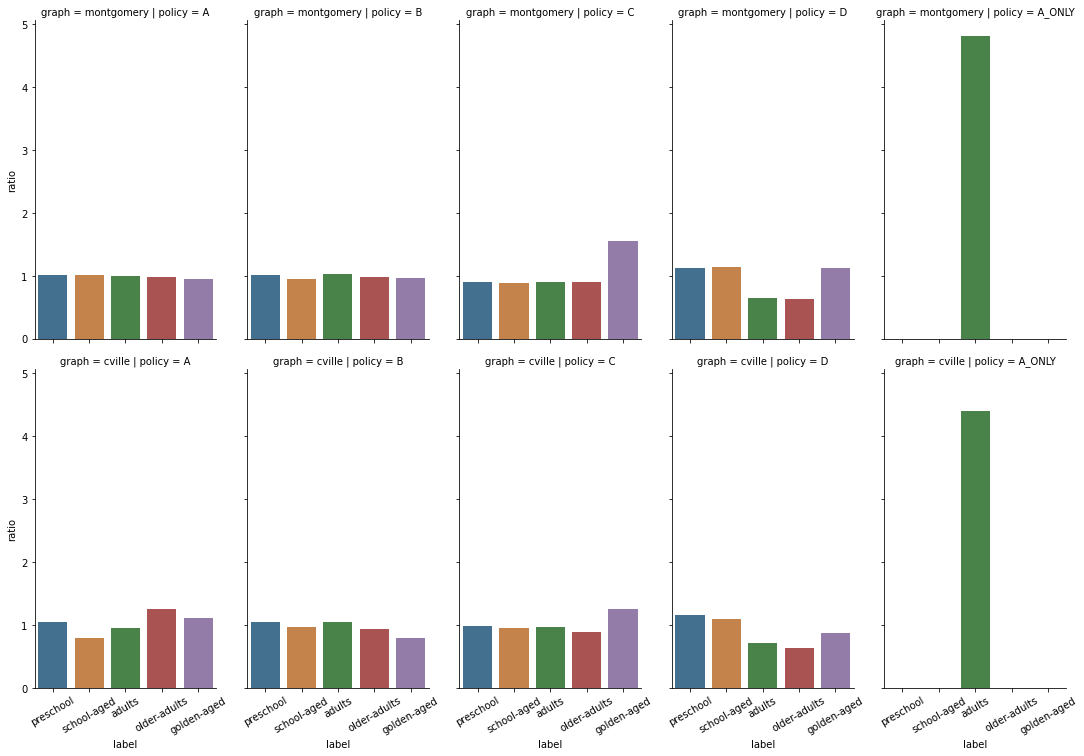

In [18]:
g = sns.catplot(x="label", y="ratio", col="policy", row="graph",
                data=melted, saturation=.5,
                kind="bar", ci=None, aspect=.6)
g.set_xticklabels(rotation=30)

In [19]:
graphs["montgomery"].nodes[0]

{'age_group': 2, 'compliance_rate_og': 0.8402347191484095}

In [20]:
import json
### Analysis of infection state
entry_id = 0
meta = df.loc[entry_id]
with open(run_dir / "data" / str(entry_id) / "sir_history.json", "r") as f:
    sir_history = json.load(f)


In [21]:
actions = [step['action'] for step in sir_history]
sir_list = {k: [step['state'][k] for step in sir_history] for k in ["S", "I1", "I2", "R"]}
sir_list["I"] = [i1 + i2 for i1, i2 in zip(sir_list["I1"], sir_list["I2"])]
print('Unique I: ', all(np.unique(x).size == len(x) for x in sir_list["I"]))

Unique I:  True


In [ ]:
f = np.mean(list(filter(lambda x: x is not None, ratios)), axis=0)

In [ ]:
sir_size = {k: list(map(len, v)) for k, v in sir_list.items()}
sir_size['I']

In [ ]:
labels = ["S", "I1", "I2", "R"]
colors = None
plt.stackplot(range(len(sir_size['S'])), [sir_size[x] for x in labels], labels=labels, colors=colors)
plt.legend(loc='upper left')

In [25]:
d = pd.DataFrame()
d["test"] = pd.Series([{"a": 1, "b": 2}, {"a": 2, "b": 3}, {"a": 4, "b": 5}])

In [27]:
pd.json_normalize(d['test'])

,a,b
0,1,2
1,2,3
2,4,5


In [ ]:
filename = "run_5mxQv"

def seg_graph(filename):
    df = pd.read_csv(PROJECT_ROOT / "output" / "run_HHUqV" / "results.csv").replace({"DepRound_fair":"DepRound Full",
              "DegGreedy_fair":"DegGreedy Full"})
    df_avg = pd.read_csv(PROJECT_ROOT / "output" / "run_BxjJA" / "results.csv").replace({"DepRound_fair":"DepRound Average",
              "DegGreedy_fair":"DegGreedy Average", "DepRound_simplified":"DepRound Impoverished"})
    df_seg = pd.read_csv(PROJECT_ROOT / "output" / filename / "results.csv").replace({"segmented_greedy": "Segmented Degree"})
    df = pd.concat([df, df_avg, df_seg])

    df = df[(df["agent"]!="Random") & (df["agent"]!="EC") & (df['agent']!= "DepRound Average") 
            & (df['agent']!= "DepRound Full") & (df['agent']!= "DepRound Impoverished")]
    df = df.rename(columns={"agent":"Alg for MinExposed"})

    df["infection_list"] = df["infections_step"].apply(lambda x: [int(i) for i in x.strip("[]").split(", ")])
    df["time_steps"] = df["infection_list"].apply(lambda x: len(x))
    df["time_step_peak"] = df["infection_list"].apply(lambda x: x.index(max(x)))
    df["peak_count"] = df["infection_list"].apply(lambda x: max(x))

    def size(name: str):
        if name[0] == "c": return 131219
        else: return 75457

    df["infected"] = df.apply(lambda x: 100.0*x["infection_count"]/size(x["G"]), axis = 1)
    df["peak"] = df.apply(lambda x: 100.0*x["peak_count"]/size(x["G"]), axis = 1)

    fig, ax = plt.subplots(1,1,figsize=(5,3))
    
    if (df["G"].iloc[0][0]) == "c":
        min_left = 720
        left = 900
        right = 1800
        max_right = 2270
        middle = 1350
    else:
        min_left = 400
        left = 500
        right = 1000
        max_right = 1250
        middle = 750
    
    import seaborn as sns

    ax = sns.lineplot(data=df, x="budget", y="infected", hue= "Alg for MinExposed", ax=ax)
    ax.get_legend().remove()
    ax.set_xlabel("Budget")
    ax.set_ylabel("Total Infections (% of Population)")
    ax.axvline(x=left, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
    ax.axvline(x=right, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
    ax.text(middle, 49, 'Status-quo estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
    #ax[0].text(830, 41, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
    ax.axvspan(left, right, alpha=0.08, color='red')
    ax.set_xlim(min_left, max_right)
    
    fig.legend(["DegGreedy Full", "Degree", "DegGreedy Average", "Segmented Degree"], title = "Algorithm for MinExposed", loc="upper left", bbox_to_anchor=(0.9, 0.9), prop={'size':10})
    #fig.savefig('../output/plots/cville_average_info.png', dpi=300, bbox_inches = 'tight')
    plt.show()

seg_graph(filename)